#  <center>Brazilian traffic sign recognition: an neural network approach</center>

## 1. Introduction

Besides autonomous cars technology is actually a trending subject in researches, many subfuctions of a car's embedded system has already been developed and it's currently working in nowadays cars (maybe not in popular ones). Traffic signs recognition (TSR) is one of those already done functions and it has a good performance, but as a driver assistant not as a controller product. Additionally, the recognition system is usually created based in the manufacture country regulations and features. As basically all cars sold in Brazil has imported technology, it's recognition function is disconnected from the system as it has no use there.

This paper propose the creation of a dataset based in Brazil's traffic signs regulation, as well a artificial intelligence (AI) application based in training a neural network to classify it. The AI was implemented in TensorFlow framework for Python 3.7.


![Examples of brazilian's Traffic signs](http://www.betuseal.com.br/wp-content/uploads/2015/01/placas-transito-sinaliza%C3%A7%C3%A3o-675x414.jpg)

### 1.1 Libraries used:

- Matplotlib: Python 2D plotting library;
- NumPY: Python math package to work with arrays, vectors and matrices;
- OS: File and Directory Access;
- OpenCV: Image data processing;
- Sklearn: Data mining and data analysis;
- Skimage: Image data processing;
- TensorFlow: Machine Learning framework.

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from random import choice
from random import randint
from random import uniform

## 2. Creating the dataset

Examples of Brazilian traffic signs can be individually gathered in [Detran/SE](http://www.detran.se.gov.br/educ_sinal.asp) web site, although it is a manual task, it wouldn't take so long to finish.

<table><tr><td><img width=100 src='traffic_signs_classes/0.png'></td><td><img width=100 src='traffic_signs_classes/6.png'></td><td><img width=100 src='traffic_signs_classes/12.png'></td><td><img width=100 src='traffic_signs_classes/13.png'></td></tr></table>

As traffic sign has a default shape, it allows removing any unnecessary part and retaining only the important details, reducing the number of data and so, optimizing for data processing.


There are differents borders and shapes of signs, as illustrated above, which indicates it's objective (warning, regulation and directions) but it doens't offer any precious information about the sign meaning, so as the colors used. Such statement allow us to reduce data number  without losing any important feature for recognition by previously removing the sign background and convert it to gray scale.

Due to remove the signs background, It was manually created a image for each sign in directory "thresholding", which contain only the background in the shape of the corresponding sign, also this image has the same name as the original sign for implementation facilities. The examples of thresholding images for the shown signs are demonstrated below.

<table><tr><td><img width=100 src='traffic_signs_classes/thresholding/0.jpg'></td><td><img width=100 src='traffic_signs_classes/thresholding/6.jpg'></td><td><img width=100 src='traffic_signs_classes/thresholding/12.jpg'></td><td><img width=100 src='traffic_signs_classes/thresholding/13.jpg'></td></tr></table>

Thinking in a real world application, the sign wouldn't be in perfect state and possibly in a different perspective as it should be, so it would be necessary to create those conditions to relate this possibilities to a label. From the 30 signs gathered in the previous database, a total of 500 synthesized versions for each sign were created. Each one of these versions proposes random geometry distortions, brightness, contrast, blur and noises effects, and at least, it is saved as a 56x56 gray pixels gray scale image, as its ilustraded below.

<table><tr><td><img width=100 src='Generated/0/0_1.png'></td><td><img width=100 src='Generated/6/6_7.png'></td><td><img width=100 src='Generated/12/12_13.png'></td><td><img width=100 src='Generated/13/13_14.png'></td></tr></table>

After all the image processing, our Brazilian traffic sign image dataset is created.

In [10]:
def pespective(input, mascara):
    cols = input.shape[1]
    rows = input.shape[0]
    inputQuad = np.array([[0, 0],[cols, 0],[cols,rows],[0,rows]], np.float32)
    outputQuad = np.array([[-randint(0,17),-randint(0,17)],[cols+randint(0,17),-randint(0,17)],	
	[cols+randint(0,17), rows+randint(0,17)],[-randint(0,17),rows+randint(0,17)]], np.float32)
    M = cv2.getPerspectiveTransform(outputQuad, inputQuad)
    output = cv2.warpPerspective(input,M,(cols,rows)) 
    output2 = cv2.warpPerspective(mascara,M,(cols,rows)) 
    return [output,output2]


'''
Apply 2D rotation and perspective transformation
'''

def transformation(name, name2):
    src1 = cv2.imread(name, 0)
    mask = cv2.imread(name2, 0)
    
    '''
    noise application
    '''
    
    rows, cols = src1.shape
    k = 0
    for i in range(0, rows):
        for j in range(0, cols):
            editValue = src1[i, j]
            var = randint(25, 100)
            k = var
            if editValue > 60 and editValue < 160:
                src1[i, j] = var
            elif editValue > 230 and editValue < 256:
                src1[i, j] = 255 - var
    if k > 40:
        getElement = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        src1 = cv2.erode(src1, getElement)

        getElement = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        src1 = cv2.dilate(src1, getElement)

    '''
    rotation transformation (-20 ate 20 graus)
    '''
    
    image_center = tuple(np.array(src1.shape) / 2)
    angle = randint(-30, 30)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(src1, rot_mat, src1.shape, flags=cv2.INTER_LINEAR)
    result2 = cv2.warpAffine(mask, rot_mat, mask.shape, flags=cv2.INTER_LINEAR)     


    '''
    perspective transformation
    '''
    
    img = result
    rows = img.shape[0]
    cols = img.shape[1]
    pts1 = np.float32([[0, 0], [0, 200], [200, 0], [200, 200]])
    seed = randint(0, 1)
    variation1 = randint(0, 8)
    variation2 = randint(15, 25)

    # right direction perspective
    if seed == 0:
        pts2 = np.float32([[(0 + variation1), 0], [(0 + variation1),
                                                   200], [(200 - variation2), 0], [(200 - variation2), 200]])
    # left direction perspective
    else:
        pts2 = np.float32([[(0 + variation2), 0], [(0 + variation2),
                                                   200], [(200 - variation1), 0], [(200 - variation1), 200]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img, M, (200, 200))
    dst2 = cv2.warpPerspective(result2, M, (200, 200))
    
    return [dst, dst2]



'''
Save resized image after applying random brightness, constrast and blur effect
'''

def variation(image,mascara, pasta, arquivo, transf):
    
    # alpha random values (simple contrast control) (0.4 - 0.9)
    alpha = uniform(.4, .9)

    # beta random values (simple brightness control) (10 - 20)
    beta = randint(12, 16)
    
    cv2.convertScaleAbs(image, image, alpha, beta)

    # add gaussian blurring
    size = int(choice('35'))
    blur = cv2.GaussianBlur(image, (size, size), 0, 0)
    uhu =  cv2.medianBlur(blur,5)    
    th, mask_th = cv2.threshold(mascara, 50, 255, cv2.THRESH_BINARY);
    blur = cv2.bitwise_and(uhu, mask_th)
    final = cv2.resize(blur, (56, 56))
  
    
    cv2.imwrite("Generated/" + str(pasta)+ "/"+ str(arquivo) + "_" +str(transf) + ".png", final)

    
'''
Import each image and pass it data as arguments to the image processing functions
In the end of it's execution, all the synthesized images will be saved in "Generated" directory
'''

def create_database():
    flag_name = 0
    for i in range(0, 29):
        filepath = './traffic_signs_classes/' + str(i) + '.png'
        filepath2 = './traffic_signs_classes/thresholding/' + str(i) + '.jpg'
        for j in range(0, 25):
            src, mask = transformation(filepath, filepath2)
            for transf in range(0, 20):
                src2, mask2 = pespective(src, mask)
                variation(src2, mask, i, j, transf)
                #print('Class: ' + str(i) + ' Image : ' + str(j) + ' Transformation : ' + str(transf))
    print('Dataset successfully created!')


'''
'''

create_database()


Class: 0 Image : 0 Transformation : 0
Class: 0 Image : 0 Transformation : 1
Class: 0 Image : 0 Transformation : 2
Class: 0 Image : 0 Transformation : 3
Class: 0 Image : 0 Transformation : 4
Class: 0 Image : 0 Transformation : 5
Class: 0 Image : 0 Transformation : 6
Class: 0 Image : 0 Transformation : 7
Class: 0 Image : 0 Transformation : 8
Class: 0 Image : 0 Transformation : 9
Class: 0 Image : 0 Transformation : 10
Class: 0 Image : 0 Transformation : 11
Class: 0 Image : 0 Transformation : 12
Class: 0 Image : 0 Transformation : 13
Class: 0 Image : 0 Transformation : 14
Class: 0 Image : 0 Transformation : 15
Class: 0 Image : 0 Transformation : 16
Class: 0 Image : 0 Transformation : 17
Class: 0 Image : 0 Transformation : 18
Class: 0 Image : 0 Transformation : 19
Class: 0 Image : 1 Transformation : 0
Class: 0 Image : 1 Transformation : 1
Class: 0 Image : 1 Transformation : 2
Class: 0 Image : 1 Transformation : 3
Class: 0 Image : 1 Transformation : 4
Class: 0 Image : 1 Transformation : 5
Cl

Class: 0 Image : 11 Transformation : 0
Class: 0 Image : 11 Transformation : 1
Class: 0 Image : 11 Transformation : 2
Class: 0 Image : 11 Transformation : 3
Class: 0 Image : 11 Transformation : 4
Class: 0 Image : 11 Transformation : 5
Class: 0 Image : 11 Transformation : 6
Class: 0 Image : 11 Transformation : 7
Class: 0 Image : 11 Transformation : 8
Class: 0 Image : 11 Transformation : 9
Class: 0 Image : 11 Transformation : 10
Class: 0 Image : 11 Transformation : 11
Class: 0 Image : 11 Transformation : 12
Class: 0 Image : 11 Transformation : 13
Class: 0 Image : 11 Transformation : 14
Class: 0 Image : 11 Transformation : 15
Class: 0 Image : 11 Transformation : 16
Class: 0 Image : 11 Transformation : 17
Class: 0 Image : 11 Transformation : 18
Class: 0 Image : 11 Transformation : 19
Class: 0 Image : 12 Transformation : 0
Class: 0 Image : 12 Transformation : 1
Class: 0 Image : 12 Transformation : 2
Class: 0 Image : 12 Transformation : 3
Class: 0 Image : 12 Transformation : 4
Class: 0 Image 

Class: 0 Image : 22 Transformation : 0
Class: 0 Image : 22 Transformation : 1
Class: 0 Image : 22 Transformation : 2
Class: 0 Image : 22 Transformation : 3
Class: 0 Image : 22 Transformation : 4
Class: 0 Image : 22 Transformation : 5
Class: 0 Image : 22 Transformation : 6
Class: 0 Image : 22 Transformation : 7
Class: 0 Image : 22 Transformation : 8
Class: 0 Image : 22 Transformation : 9
Class: 0 Image : 22 Transformation : 10
Class: 0 Image : 22 Transformation : 11
Class: 0 Image : 22 Transformation : 12
Class: 0 Image : 22 Transformation : 13
Class: 0 Image : 22 Transformation : 14
Class: 0 Image : 22 Transformation : 15
Class: 0 Image : 22 Transformation : 16
Class: 0 Image : 22 Transformation : 17
Class: 0 Image : 22 Transformation : 18
Class: 0 Image : 22 Transformation : 19
Class: 0 Image : 23 Transformation : 0
Class: 0 Image : 23 Transformation : 1
Class: 0 Image : 23 Transformation : 2
Class: 0 Image : 23 Transformation : 3
Class: 0 Image : 23 Transformation : 4
Class: 0 Image 

Class: 1 Image : 8 Transformation : 0
Class: 1 Image : 8 Transformation : 1
Class: 1 Image : 8 Transformation : 2
Class: 1 Image : 8 Transformation : 3
Class: 1 Image : 8 Transformation : 4
Class: 1 Image : 8 Transformation : 5
Class: 1 Image : 8 Transformation : 6
Class: 1 Image : 8 Transformation : 7
Class: 1 Image : 8 Transformation : 8
Class: 1 Image : 8 Transformation : 9
Class: 1 Image : 8 Transformation : 10
Class: 1 Image : 8 Transformation : 11
Class: 1 Image : 8 Transformation : 12
Class: 1 Image : 8 Transformation : 13
Class: 1 Image : 8 Transformation : 14
Class: 1 Image : 8 Transformation : 15
Class: 1 Image : 8 Transformation : 16
Class: 1 Image : 8 Transformation : 17
Class: 1 Image : 8 Transformation : 18
Class: 1 Image : 8 Transformation : 19
Class: 1 Image : 9 Transformation : 0
Class: 1 Image : 9 Transformation : 1
Class: 1 Image : 9 Transformation : 2
Class: 1 Image : 9 Transformation : 3
Class: 1 Image : 9 Transformation : 4
Class: 1 Image : 9 Transformation : 5
Cl

Class: 1 Image : 19 Transformation : 0
Class: 1 Image : 19 Transformation : 1
Class: 1 Image : 19 Transformation : 2
Class: 1 Image : 19 Transformation : 3
Class: 1 Image : 19 Transformation : 4
Class: 1 Image : 19 Transformation : 5
Class: 1 Image : 19 Transformation : 6
Class: 1 Image : 19 Transformation : 7
Class: 1 Image : 19 Transformation : 8
Class: 1 Image : 19 Transformation : 9
Class: 1 Image : 19 Transformation : 10
Class: 1 Image : 19 Transformation : 11
Class: 1 Image : 19 Transformation : 12
Class: 1 Image : 19 Transformation : 13
Class: 1 Image : 19 Transformation : 14
Class: 1 Image : 19 Transformation : 15
Class: 1 Image : 19 Transformation : 16
Class: 1 Image : 19 Transformation : 17
Class: 1 Image : 19 Transformation : 18
Class: 1 Image : 19 Transformation : 19
Class: 1 Image : 20 Transformation : 0
Class: 1 Image : 20 Transformation : 1
Class: 1 Image : 20 Transformation : 2
Class: 1 Image : 20 Transformation : 3
Class: 1 Image : 20 Transformation : 4
Class: 1 Image 

Class: 2 Image : 5 Transformation : 0
Class: 2 Image : 5 Transformation : 1
Class: 2 Image : 5 Transformation : 2
Class: 2 Image : 5 Transformation : 3
Class: 2 Image : 5 Transformation : 4
Class: 2 Image : 5 Transformation : 5
Class: 2 Image : 5 Transformation : 6
Class: 2 Image : 5 Transformation : 7
Class: 2 Image : 5 Transformation : 8
Class: 2 Image : 5 Transformation : 9
Class: 2 Image : 5 Transformation : 10
Class: 2 Image : 5 Transformation : 11
Class: 2 Image : 5 Transformation : 12
Class: 2 Image : 5 Transformation : 13
Class: 2 Image : 5 Transformation : 14
Class: 2 Image : 5 Transformation : 15
Class: 2 Image : 5 Transformation : 16
Class: 2 Image : 5 Transformation : 17
Class: 2 Image : 5 Transformation : 18
Class: 2 Image : 5 Transformation : 19
Class: 2 Image : 6 Transformation : 0
Class: 2 Image : 6 Transformation : 1
Class: 2 Image : 6 Transformation : 2
Class: 2 Image : 6 Transformation : 3
Class: 2 Image : 6 Transformation : 4
Class: 2 Image : 6 Transformation : 5
Cl

Class: 2 Image : 16 Transformation : 0
Class: 2 Image : 16 Transformation : 1
Class: 2 Image : 16 Transformation : 2
Class: 2 Image : 16 Transformation : 3
Class: 2 Image : 16 Transformation : 4
Class: 2 Image : 16 Transformation : 5
Class: 2 Image : 16 Transformation : 6
Class: 2 Image : 16 Transformation : 7
Class: 2 Image : 16 Transformation : 8
Class: 2 Image : 16 Transformation : 9
Class: 2 Image : 16 Transformation : 10
Class: 2 Image : 16 Transformation : 11
Class: 2 Image : 16 Transformation : 12
Class: 2 Image : 16 Transformation : 13
Class: 2 Image : 16 Transformation : 14
Class: 2 Image : 16 Transformation : 15
Class: 2 Image : 16 Transformation : 16
Class: 2 Image : 16 Transformation : 17
Class: 2 Image : 16 Transformation : 18
Class: 2 Image : 16 Transformation : 19
Class: 2 Image : 17 Transformation : 0
Class: 2 Image : 17 Transformation : 1
Class: 2 Image : 17 Transformation : 2
Class: 2 Image : 17 Transformation : 3
Class: 2 Image : 17 Transformation : 4
Class: 2 Image 

Class: 3 Image : 2 Transformation : 0
Class: 3 Image : 2 Transformation : 1
Class: 3 Image : 2 Transformation : 2
Class: 3 Image : 2 Transformation : 3
Class: 3 Image : 2 Transformation : 4
Class: 3 Image : 2 Transformation : 5
Class: 3 Image : 2 Transformation : 6
Class: 3 Image : 2 Transformation : 7
Class: 3 Image : 2 Transformation : 8
Class: 3 Image : 2 Transformation : 9
Class: 3 Image : 2 Transformation : 10
Class: 3 Image : 2 Transformation : 11
Class: 3 Image : 2 Transformation : 12
Class: 3 Image : 2 Transformation : 13
Class: 3 Image : 2 Transformation : 14
Class: 3 Image : 2 Transformation : 15
Class: 3 Image : 2 Transformation : 16
Class: 3 Image : 2 Transformation : 17
Class: 3 Image : 2 Transformation : 18
Class: 3 Image : 2 Transformation : 19
Class: 3 Image : 3 Transformation : 0
Class: 3 Image : 3 Transformation : 1
Class: 3 Image : 3 Transformation : 2
Class: 3 Image : 3 Transformation : 3
Class: 3 Image : 3 Transformation : 4
Class: 3 Image : 3 Transformation : 5
Cl

Class: 3 Image : 13 Transformation : 0
Class: 3 Image : 13 Transformation : 1
Class: 3 Image : 13 Transformation : 2
Class: 3 Image : 13 Transformation : 3
Class: 3 Image : 13 Transformation : 4
Class: 3 Image : 13 Transformation : 5
Class: 3 Image : 13 Transformation : 6
Class: 3 Image : 13 Transformation : 7
Class: 3 Image : 13 Transformation : 8
Class: 3 Image : 13 Transformation : 9
Class: 3 Image : 13 Transformation : 10
Class: 3 Image : 13 Transformation : 11
Class: 3 Image : 13 Transformation : 12
Class: 3 Image : 13 Transformation : 13
Class: 3 Image : 13 Transformation : 14
Class: 3 Image : 13 Transformation : 15
Class: 3 Image : 13 Transformation : 16
Class: 3 Image : 13 Transformation : 17
Class: 3 Image : 13 Transformation : 18
Class: 3 Image : 13 Transformation : 19
Class: 3 Image : 14 Transformation : 0
Class: 3 Image : 14 Transformation : 1
Class: 3 Image : 14 Transformation : 2
Class: 3 Image : 14 Transformation : 3
Class: 3 Image : 14 Transformation : 4
Class: 3 Image 

Class: 3 Image : 24 Transformation : 0
Class: 3 Image : 24 Transformation : 1
Class: 3 Image : 24 Transformation : 2
Class: 3 Image : 24 Transformation : 3
Class: 3 Image : 24 Transformation : 4
Class: 3 Image : 24 Transformation : 5
Class: 3 Image : 24 Transformation : 6
Class: 3 Image : 24 Transformation : 7
Class: 3 Image : 24 Transformation : 8
Class: 3 Image : 24 Transformation : 9
Class: 3 Image : 24 Transformation : 10
Class: 3 Image : 24 Transformation : 11
Class: 3 Image : 24 Transformation : 12
Class: 3 Image : 24 Transformation : 13
Class: 3 Image : 24 Transformation : 14
Class: 3 Image : 24 Transformation : 15
Class: 3 Image : 24 Transformation : 16
Class: 3 Image : 24 Transformation : 17
Class: 3 Image : 24 Transformation : 18
Class: 3 Image : 24 Transformation : 19
Class: 4 Image : 0 Transformation : 0
Class: 4 Image : 0 Transformation : 1
Class: 4 Image : 0 Transformation : 2
Class: 4 Image : 0 Transformation : 3
Class: 4 Image : 0 Transformation : 4
Class: 4 Image : 0 T

Class: 4 Image : 10 Transformation : 0
Class: 4 Image : 10 Transformation : 1
Class: 4 Image : 10 Transformation : 2
Class: 4 Image : 10 Transformation : 3
Class: 4 Image : 10 Transformation : 4
Class: 4 Image : 10 Transformation : 5
Class: 4 Image : 10 Transformation : 6
Class: 4 Image : 10 Transformation : 7
Class: 4 Image : 10 Transformation : 8
Class: 4 Image : 10 Transformation : 9
Class: 4 Image : 10 Transformation : 10
Class: 4 Image : 10 Transformation : 11
Class: 4 Image : 10 Transformation : 12
Class: 4 Image : 10 Transformation : 13
Class: 4 Image : 10 Transformation : 14
Class: 4 Image : 10 Transformation : 15
Class: 4 Image : 10 Transformation : 16
Class: 4 Image : 10 Transformation : 17
Class: 4 Image : 10 Transformation : 18
Class: 4 Image : 10 Transformation : 19
Class: 4 Image : 11 Transformation : 0
Class: 4 Image : 11 Transformation : 1
Class: 4 Image : 11 Transformation : 2
Class: 4 Image : 11 Transformation : 3
Class: 4 Image : 11 Transformation : 4
Class: 4 Image 

Class: 4 Image : 21 Transformation : 0
Class: 4 Image : 21 Transformation : 1
Class: 4 Image : 21 Transformation : 2
Class: 4 Image : 21 Transformation : 3
Class: 4 Image : 21 Transformation : 4
Class: 4 Image : 21 Transformation : 5
Class: 4 Image : 21 Transformation : 6
Class: 4 Image : 21 Transformation : 7
Class: 4 Image : 21 Transformation : 8
Class: 4 Image : 21 Transformation : 9
Class: 4 Image : 21 Transformation : 10
Class: 4 Image : 21 Transformation : 11
Class: 4 Image : 21 Transformation : 12
Class: 4 Image : 21 Transformation : 13
Class: 4 Image : 21 Transformation : 14
Class: 4 Image : 21 Transformation : 15
Class: 4 Image : 21 Transformation : 16
Class: 4 Image : 21 Transformation : 17
Class: 4 Image : 21 Transformation : 18
Class: 4 Image : 21 Transformation : 19
Class: 4 Image : 22 Transformation : 0
Class: 4 Image : 22 Transformation : 1
Class: 4 Image : 22 Transformation : 2
Class: 4 Image : 22 Transformation : 3
Class: 4 Image : 22 Transformation : 4
Class: 4 Image 

Class: 5 Image : 7 Transformation : 0
Class: 5 Image : 7 Transformation : 1
Class: 5 Image : 7 Transformation : 2
Class: 5 Image : 7 Transformation : 3
Class: 5 Image : 7 Transformation : 4
Class: 5 Image : 7 Transformation : 5
Class: 5 Image : 7 Transformation : 6
Class: 5 Image : 7 Transformation : 7
Class: 5 Image : 7 Transformation : 8
Class: 5 Image : 7 Transformation : 9
Class: 5 Image : 7 Transformation : 10
Class: 5 Image : 7 Transformation : 11
Class: 5 Image : 7 Transformation : 12
Class: 5 Image : 7 Transformation : 13
Class: 5 Image : 7 Transformation : 14
Class: 5 Image : 7 Transformation : 15
Class: 5 Image : 7 Transformation : 16
Class: 5 Image : 7 Transformation : 17
Class: 5 Image : 7 Transformation : 18
Class: 5 Image : 7 Transformation : 19
Class: 5 Image : 8 Transformation : 0
Class: 5 Image : 8 Transformation : 1
Class: 5 Image : 8 Transformation : 2
Class: 5 Image : 8 Transformation : 3
Class: 5 Image : 8 Transformation : 4
Class: 5 Image : 8 Transformation : 5
Cl

Class: 5 Image : 18 Transformation : 0
Class: 5 Image : 18 Transformation : 1
Class: 5 Image : 18 Transformation : 2
Class: 5 Image : 18 Transformation : 3
Class: 5 Image : 18 Transformation : 4
Class: 5 Image : 18 Transformation : 5
Class: 5 Image : 18 Transformation : 6
Class: 5 Image : 18 Transformation : 7
Class: 5 Image : 18 Transformation : 8
Class: 5 Image : 18 Transformation : 9
Class: 5 Image : 18 Transformation : 10
Class: 5 Image : 18 Transformation : 11
Class: 5 Image : 18 Transformation : 12
Class: 5 Image : 18 Transformation : 13
Class: 5 Image : 18 Transformation : 14
Class: 5 Image : 18 Transformation : 15
Class: 5 Image : 18 Transformation : 16
Class: 5 Image : 18 Transformation : 17
Class: 5 Image : 18 Transformation : 18
Class: 5 Image : 18 Transformation : 19
Class: 5 Image : 19 Transformation : 0
Class: 5 Image : 19 Transformation : 1
Class: 5 Image : 19 Transformation : 2
Class: 5 Image : 19 Transformation : 3
Class: 5 Image : 19 Transformation : 4
Class: 5 Image 

Class: 6 Image : 4 Transformation : 0
Class: 6 Image : 4 Transformation : 1
Class: 6 Image : 4 Transformation : 2
Class: 6 Image : 4 Transformation : 3
Class: 6 Image : 4 Transformation : 4
Class: 6 Image : 4 Transformation : 5
Class: 6 Image : 4 Transformation : 6
Class: 6 Image : 4 Transformation : 7
Class: 6 Image : 4 Transformation : 8
Class: 6 Image : 4 Transformation : 9
Class: 6 Image : 4 Transformation : 10
Class: 6 Image : 4 Transformation : 11
Class: 6 Image : 4 Transformation : 12
Class: 6 Image : 4 Transformation : 13
Class: 6 Image : 4 Transformation : 14
Class: 6 Image : 4 Transformation : 15
Class: 6 Image : 4 Transformation : 16
Class: 6 Image : 4 Transformation : 17
Class: 6 Image : 4 Transformation : 18
Class: 6 Image : 4 Transformation : 19
Class: 6 Image : 5 Transformation : 0
Class: 6 Image : 5 Transformation : 1
Class: 6 Image : 5 Transformation : 2
Class: 6 Image : 5 Transformation : 3
Class: 6 Image : 5 Transformation : 4
Class: 6 Image : 5 Transformation : 5
Cl

Class: 6 Image : 15 Transformation : 0
Class: 6 Image : 15 Transformation : 1
Class: 6 Image : 15 Transformation : 2
Class: 6 Image : 15 Transformation : 3
Class: 6 Image : 15 Transformation : 4
Class: 6 Image : 15 Transformation : 5
Class: 6 Image : 15 Transformation : 6
Class: 6 Image : 15 Transformation : 7
Class: 6 Image : 15 Transformation : 8
Class: 6 Image : 15 Transformation : 9
Class: 6 Image : 15 Transformation : 10
Class: 6 Image : 15 Transformation : 11
Class: 6 Image : 15 Transformation : 12
Class: 6 Image : 15 Transformation : 13
Class: 6 Image : 15 Transformation : 14
Class: 6 Image : 15 Transformation : 15
Class: 6 Image : 15 Transformation : 16
Class: 6 Image : 15 Transformation : 17
Class: 6 Image : 15 Transformation : 18
Class: 6 Image : 15 Transformation : 19
Class: 6 Image : 16 Transformation : 0
Class: 6 Image : 16 Transformation : 1
Class: 6 Image : 16 Transformation : 2
Class: 6 Image : 16 Transformation : 3
Class: 6 Image : 16 Transformation : 4
Class: 6 Image 

Class: 7 Image : 1 Transformation : 0
Class: 7 Image : 1 Transformation : 1
Class: 7 Image : 1 Transformation : 2
Class: 7 Image : 1 Transformation : 3
Class: 7 Image : 1 Transformation : 4
Class: 7 Image : 1 Transformation : 5
Class: 7 Image : 1 Transformation : 6
Class: 7 Image : 1 Transformation : 7
Class: 7 Image : 1 Transformation : 8
Class: 7 Image : 1 Transformation : 9
Class: 7 Image : 1 Transformation : 10
Class: 7 Image : 1 Transformation : 11
Class: 7 Image : 1 Transformation : 12
Class: 7 Image : 1 Transformation : 13
Class: 7 Image : 1 Transformation : 14
Class: 7 Image : 1 Transformation : 15
Class: 7 Image : 1 Transformation : 16
Class: 7 Image : 1 Transformation : 17
Class: 7 Image : 1 Transformation : 18
Class: 7 Image : 1 Transformation : 19
Class: 7 Image : 2 Transformation : 0
Class: 7 Image : 2 Transformation : 1
Class: 7 Image : 2 Transformation : 2
Class: 7 Image : 2 Transformation : 3
Class: 7 Image : 2 Transformation : 4
Class: 7 Image : 2 Transformation : 5
Cl

Class: 7 Image : 12 Transformation : 0
Class: 7 Image : 12 Transformation : 1
Class: 7 Image : 12 Transformation : 2
Class: 7 Image : 12 Transformation : 3
Class: 7 Image : 12 Transformation : 4
Class: 7 Image : 12 Transformation : 5
Class: 7 Image : 12 Transformation : 6
Class: 7 Image : 12 Transformation : 7
Class: 7 Image : 12 Transformation : 8
Class: 7 Image : 12 Transformation : 9
Class: 7 Image : 12 Transformation : 10
Class: 7 Image : 12 Transformation : 11
Class: 7 Image : 12 Transformation : 12
Class: 7 Image : 12 Transformation : 13
Class: 7 Image : 12 Transformation : 14
Class: 7 Image : 12 Transformation : 15
Class: 7 Image : 12 Transformation : 16
Class: 7 Image : 12 Transformation : 17
Class: 7 Image : 12 Transformation : 18
Class: 7 Image : 12 Transformation : 19
Class: 7 Image : 13 Transformation : 0
Class: 7 Image : 13 Transformation : 1
Class: 7 Image : 13 Transformation : 2
Class: 7 Image : 13 Transformation : 3
Class: 7 Image : 13 Transformation : 4
Class: 7 Image 

Class: 7 Image : 23 Transformation : 0
Class: 7 Image : 23 Transformation : 1
Class: 7 Image : 23 Transformation : 2
Class: 7 Image : 23 Transformation : 3
Class: 7 Image : 23 Transformation : 4
Class: 7 Image : 23 Transformation : 5
Class: 7 Image : 23 Transformation : 6
Class: 7 Image : 23 Transformation : 7
Class: 7 Image : 23 Transformation : 8
Class: 7 Image : 23 Transformation : 9
Class: 7 Image : 23 Transformation : 10
Class: 7 Image : 23 Transformation : 11
Class: 7 Image : 23 Transformation : 12
Class: 7 Image : 23 Transformation : 13
Class: 7 Image : 23 Transformation : 14
Class: 7 Image : 23 Transformation : 15
Class: 7 Image : 23 Transformation : 16
Class: 7 Image : 23 Transformation : 17
Class: 7 Image : 23 Transformation : 18
Class: 7 Image : 23 Transformation : 19
Class: 7 Image : 24 Transformation : 0
Class: 7 Image : 24 Transformation : 1
Class: 7 Image : 24 Transformation : 2
Class: 7 Image : 24 Transformation : 3
Class: 7 Image : 24 Transformation : 4
Class: 7 Image 

Class: 8 Image : 9 Transformation : 0
Class: 8 Image : 9 Transformation : 1
Class: 8 Image : 9 Transformation : 2
Class: 8 Image : 9 Transformation : 3
Class: 8 Image : 9 Transformation : 4
Class: 8 Image : 9 Transformation : 5
Class: 8 Image : 9 Transformation : 6
Class: 8 Image : 9 Transformation : 7
Class: 8 Image : 9 Transformation : 8
Class: 8 Image : 9 Transformation : 9
Class: 8 Image : 9 Transformation : 10
Class: 8 Image : 9 Transformation : 11
Class: 8 Image : 9 Transformation : 12
Class: 8 Image : 9 Transformation : 13
Class: 8 Image : 9 Transformation : 14
Class: 8 Image : 9 Transformation : 15
Class: 8 Image : 9 Transformation : 16
Class: 8 Image : 9 Transformation : 17
Class: 8 Image : 9 Transformation : 18
Class: 8 Image : 9 Transformation : 19
Class: 8 Image : 10 Transformation : 0
Class: 8 Image : 10 Transformation : 1
Class: 8 Image : 10 Transformation : 2
Class: 8 Image : 10 Transformation : 3
Class: 8 Image : 10 Transformation : 4
Class: 8 Image : 10 Transformation 

Class: 8 Image : 20 Transformation : 0
Class: 8 Image : 20 Transformation : 1
Class: 8 Image : 20 Transformation : 2
Class: 8 Image : 20 Transformation : 3
Class: 8 Image : 20 Transformation : 4
Class: 8 Image : 20 Transformation : 5
Class: 8 Image : 20 Transformation : 6
Class: 8 Image : 20 Transformation : 7
Class: 8 Image : 20 Transformation : 8
Class: 8 Image : 20 Transformation : 9
Class: 8 Image : 20 Transformation : 10
Class: 8 Image : 20 Transformation : 11
Class: 8 Image : 20 Transformation : 12
Class: 8 Image : 20 Transformation : 13
Class: 8 Image : 20 Transformation : 14
Class: 8 Image : 20 Transformation : 15
Class: 8 Image : 20 Transformation : 16
Class: 8 Image : 20 Transformation : 17
Class: 8 Image : 20 Transformation : 18
Class: 8 Image : 20 Transformation : 19
Class: 8 Image : 21 Transformation : 0
Class: 8 Image : 21 Transformation : 1
Class: 8 Image : 21 Transformation : 2
Class: 8 Image : 21 Transformation : 3
Class: 8 Image : 21 Transformation : 4
Class: 8 Image 

Class: 9 Image : 6 Transformation : 0
Class: 9 Image : 6 Transformation : 1
Class: 9 Image : 6 Transformation : 2
Class: 9 Image : 6 Transformation : 3
Class: 9 Image : 6 Transformation : 4
Class: 9 Image : 6 Transformation : 5
Class: 9 Image : 6 Transformation : 6
Class: 9 Image : 6 Transformation : 7
Class: 9 Image : 6 Transformation : 8
Class: 9 Image : 6 Transformation : 9
Class: 9 Image : 6 Transformation : 10
Class: 9 Image : 6 Transformation : 11
Class: 9 Image : 6 Transformation : 12
Class: 9 Image : 6 Transformation : 13
Class: 9 Image : 6 Transformation : 14
Class: 9 Image : 6 Transformation : 15
Class: 9 Image : 6 Transformation : 16
Class: 9 Image : 6 Transformation : 17
Class: 9 Image : 6 Transformation : 18
Class: 9 Image : 6 Transformation : 19
Class: 9 Image : 7 Transformation : 0
Class: 9 Image : 7 Transformation : 1
Class: 9 Image : 7 Transformation : 2
Class: 9 Image : 7 Transformation : 3
Class: 9 Image : 7 Transformation : 4
Class: 9 Image : 7 Transformation : 5
Cl

Class: 9 Image : 17 Transformation : 0
Class: 9 Image : 17 Transformation : 1
Class: 9 Image : 17 Transformation : 2
Class: 9 Image : 17 Transformation : 3
Class: 9 Image : 17 Transformation : 4
Class: 9 Image : 17 Transformation : 5
Class: 9 Image : 17 Transformation : 6
Class: 9 Image : 17 Transformation : 7
Class: 9 Image : 17 Transformation : 8
Class: 9 Image : 17 Transformation : 9
Class: 9 Image : 17 Transformation : 10
Class: 9 Image : 17 Transformation : 11
Class: 9 Image : 17 Transformation : 12
Class: 9 Image : 17 Transformation : 13
Class: 9 Image : 17 Transformation : 14
Class: 9 Image : 17 Transformation : 15
Class: 9 Image : 17 Transformation : 16
Class: 9 Image : 17 Transformation : 17
Class: 9 Image : 17 Transformation : 18
Class: 9 Image : 17 Transformation : 19
Class: 9 Image : 18 Transformation : 0
Class: 9 Image : 18 Transformation : 1
Class: 9 Image : 18 Transformation : 2
Class: 9 Image : 18 Transformation : 3
Class: 9 Image : 18 Transformation : 4
Class: 9 Image 

Class: 10 Image : 3 Transformation : 0
Class: 10 Image : 3 Transformation : 1
Class: 10 Image : 3 Transformation : 2
Class: 10 Image : 3 Transformation : 3
Class: 10 Image : 3 Transformation : 4
Class: 10 Image : 3 Transformation : 5
Class: 10 Image : 3 Transformation : 6
Class: 10 Image : 3 Transformation : 7
Class: 10 Image : 3 Transformation : 8
Class: 10 Image : 3 Transformation : 9
Class: 10 Image : 3 Transformation : 10
Class: 10 Image : 3 Transformation : 11
Class: 10 Image : 3 Transformation : 12
Class: 10 Image : 3 Transformation : 13
Class: 10 Image : 3 Transformation : 14
Class: 10 Image : 3 Transformation : 15
Class: 10 Image : 3 Transformation : 16
Class: 10 Image : 3 Transformation : 17
Class: 10 Image : 3 Transformation : 18
Class: 10 Image : 3 Transformation : 19
Class: 10 Image : 4 Transformation : 0
Class: 10 Image : 4 Transformation : 1
Class: 10 Image : 4 Transformation : 2
Class: 10 Image : 4 Transformation : 3
Class: 10 Image : 4 Transformation : 4
Class: 10 Image

Class: 10 Image : 14 Transformation : 0
Class: 10 Image : 14 Transformation : 1
Class: 10 Image : 14 Transformation : 2
Class: 10 Image : 14 Transformation : 3
Class: 10 Image : 14 Transformation : 4
Class: 10 Image : 14 Transformation : 5
Class: 10 Image : 14 Transformation : 6
Class: 10 Image : 14 Transformation : 7
Class: 10 Image : 14 Transformation : 8
Class: 10 Image : 14 Transformation : 9
Class: 10 Image : 14 Transformation : 10
Class: 10 Image : 14 Transformation : 11
Class: 10 Image : 14 Transformation : 12
Class: 10 Image : 14 Transformation : 13
Class: 10 Image : 14 Transformation : 14
Class: 10 Image : 14 Transformation : 15
Class: 10 Image : 14 Transformation : 16
Class: 10 Image : 14 Transformation : 17
Class: 10 Image : 14 Transformation : 18
Class: 10 Image : 14 Transformation : 19
Class: 10 Image : 15 Transformation : 0
Class: 10 Image : 15 Transformation : 1
Class: 10 Image : 15 Transformation : 2
Class: 10 Image : 15 Transformation : 3
Class: 10 Image : 15 Transform

Class: 11 Image : 0 Transformation : 0
Class: 11 Image : 0 Transformation : 1
Class: 11 Image : 0 Transformation : 2
Class: 11 Image : 0 Transformation : 3
Class: 11 Image : 0 Transformation : 4
Class: 11 Image : 0 Transformation : 5
Class: 11 Image : 0 Transformation : 6
Class: 11 Image : 0 Transformation : 7
Class: 11 Image : 0 Transformation : 8
Class: 11 Image : 0 Transformation : 9
Class: 11 Image : 0 Transformation : 10
Class: 11 Image : 0 Transformation : 11
Class: 11 Image : 0 Transformation : 12
Class: 11 Image : 0 Transformation : 13
Class: 11 Image : 0 Transformation : 14
Class: 11 Image : 0 Transformation : 15
Class: 11 Image : 0 Transformation : 16
Class: 11 Image : 0 Transformation : 17
Class: 11 Image : 0 Transformation : 18
Class: 11 Image : 0 Transformation : 19
Class: 11 Image : 1 Transformation : 0
Class: 11 Image : 1 Transformation : 1
Class: 11 Image : 1 Transformation : 2
Class: 11 Image : 1 Transformation : 3
Class: 11 Image : 1 Transformation : 4
Class: 11 Image

Class: 11 Image : 11 Transformation : 0
Class: 11 Image : 11 Transformation : 1
Class: 11 Image : 11 Transformation : 2
Class: 11 Image : 11 Transformation : 3
Class: 11 Image : 11 Transformation : 4
Class: 11 Image : 11 Transformation : 5
Class: 11 Image : 11 Transformation : 6
Class: 11 Image : 11 Transformation : 7
Class: 11 Image : 11 Transformation : 8
Class: 11 Image : 11 Transformation : 9
Class: 11 Image : 11 Transformation : 10
Class: 11 Image : 11 Transformation : 11
Class: 11 Image : 11 Transformation : 12
Class: 11 Image : 11 Transformation : 13
Class: 11 Image : 11 Transformation : 14
Class: 11 Image : 11 Transformation : 15
Class: 11 Image : 11 Transformation : 16
Class: 11 Image : 11 Transformation : 17
Class: 11 Image : 11 Transformation : 18
Class: 11 Image : 11 Transformation : 19
Class: 11 Image : 12 Transformation : 0
Class: 11 Image : 12 Transformation : 1
Class: 11 Image : 12 Transformation : 2
Class: 11 Image : 12 Transformation : 3
Class: 11 Image : 12 Transform

Class: 11 Image : 22 Transformation : 0
Class: 11 Image : 22 Transformation : 1
Class: 11 Image : 22 Transformation : 2
Class: 11 Image : 22 Transformation : 3
Class: 11 Image : 22 Transformation : 4
Class: 11 Image : 22 Transformation : 5
Class: 11 Image : 22 Transformation : 6
Class: 11 Image : 22 Transformation : 7
Class: 11 Image : 22 Transformation : 8
Class: 11 Image : 22 Transformation : 9
Class: 11 Image : 22 Transformation : 10
Class: 11 Image : 22 Transformation : 11
Class: 11 Image : 22 Transformation : 12
Class: 11 Image : 22 Transformation : 13
Class: 11 Image : 22 Transformation : 14
Class: 11 Image : 22 Transformation : 15
Class: 11 Image : 22 Transformation : 16
Class: 11 Image : 22 Transformation : 17
Class: 11 Image : 22 Transformation : 18
Class: 11 Image : 22 Transformation : 19
Class: 11 Image : 23 Transformation : 0
Class: 11 Image : 23 Transformation : 1
Class: 11 Image : 23 Transformation : 2
Class: 11 Image : 23 Transformation : 3
Class: 11 Image : 23 Transform

Class: 12 Image : 8 Transformation : 0
Class: 12 Image : 8 Transformation : 1
Class: 12 Image : 8 Transformation : 2
Class: 12 Image : 8 Transformation : 3
Class: 12 Image : 8 Transformation : 4
Class: 12 Image : 8 Transformation : 5
Class: 12 Image : 8 Transformation : 6
Class: 12 Image : 8 Transformation : 7
Class: 12 Image : 8 Transformation : 8
Class: 12 Image : 8 Transformation : 9
Class: 12 Image : 8 Transformation : 10
Class: 12 Image : 8 Transformation : 11
Class: 12 Image : 8 Transformation : 12
Class: 12 Image : 8 Transformation : 13
Class: 12 Image : 8 Transformation : 14
Class: 12 Image : 8 Transformation : 15
Class: 12 Image : 8 Transformation : 16
Class: 12 Image : 8 Transformation : 17
Class: 12 Image : 8 Transformation : 18
Class: 12 Image : 8 Transformation : 19
Class: 12 Image : 9 Transformation : 0
Class: 12 Image : 9 Transformation : 1
Class: 12 Image : 9 Transformation : 2
Class: 12 Image : 9 Transformation : 3
Class: 12 Image : 9 Transformation : 4
Class: 12 Image

Class: 12 Image : 19 Transformation : 0
Class: 12 Image : 19 Transformation : 1
Class: 12 Image : 19 Transformation : 2
Class: 12 Image : 19 Transformation : 3
Class: 12 Image : 19 Transformation : 4
Class: 12 Image : 19 Transformation : 5
Class: 12 Image : 19 Transformation : 6
Class: 12 Image : 19 Transformation : 7
Class: 12 Image : 19 Transformation : 8
Class: 12 Image : 19 Transformation : 9
Class: 12 Image : 19 Transformation : 10
Class: 12 Image : 19 Transformation : 11
Class: 12 Image : 19 Transformation : 12
Class: 12 Image : 19 Transformation : 13
Class: 12 Image : 19 Transformation : 14
Class: 12 Image : 19 Transformation : 15
Class: 12 Image : 19 Transformation : 16
Class: 12 Image : 19 Transformation : 17
Class: 12 Image : 19 Transformation : 18
Class: 12 Image : 19 Transformation : 19
Class: 12 Image : 20 Transformation : 0
Class: 12 Image : 20 Transformation : 1
Class: 12 Image : 20 Transformation : 2
Class: 12 Image : 20 Transformation : 3
Class: 12 Image : 20 Transform

Class: 13 Image : 5 Transformation : 0
Class: 13 Image : 5 Transformation : 1
Class: 13 Image : 5 Transformation : 2
Class: 13 Image : 5 Transformation : 3
Class: 13 Image : 5 Transformation : 4
Class: 13 Image : 5 Transformation : 5
Class: 13 Image : 5 Transformation : 6
Class: 13 Image : 5 Transformation : 7
Class: 13 Image : 5 Transformation : 8
Class: 13 Image : 5 Transformation : 9
Class: 13 Image : 5 Transformation : 10
Class: 13 Image : 5 Transformation : 11
Class: 13 Image : 5 Transformation : 12
Class: 13 Image : 5 Transformation : 13
Class: 13 Image : 5 Transformation : 14
Class: 13 Image : 5 Transformation : 15
Class: 13 Image : 5 Transformation : 16
Class: 13 Image : 5 Transformation : 17
Class: 13 Image : 5 Transformation : 18
Class: 13 Image : 5 Transformation : 19
Class: 13 Image : 6 Transformation : 0
Class: 13 Image : 6 Transformation : 1
Class: 13 Image : 6 Transformation : 2
Class: 13 Image : 6 Transformation : 3
Class: 13 Image : 6 Transformation : 4
Class: 13 Image

Class: 13 Image : 16 Transformation : 0
Class: 13 Image : 16 Transformation : 1
Class: 13 Image : 16 Transformation : 2
Class: 13 Image : 16 Transformation : 3
Class: 13 Image : 16 Transformation : 4
Class: 13 Image : 16 Transformation : 5
Class: 13 Image : 16 Transformation : 6
Class: 13 Image : 16 Transformation : 7
Class: 13 Image : 16 Transformation : 8
Class: 13 Image : 16 Transformation : 9
Class: 13 Image : 16 Transformation : 10
Class: 13 Image : 16 Transformation : 11
Class: 13 Image : 16 Transformation : 12
Class: 13 Image : 16 Transformation : 13
Class: 13 Image : 16 Transformation : 14
Class: 13 Image : 16 Transformation : 15
Class: 13 Image : 16 Transformation : 16
Class: 13 Image : 16 Transformation : 17
Class: 13 Image : 16 Transformation : 18
Class: 13 Image : 16 Transformation : 19
Class: 13 Image : 17 Transformation : 0
Class: 13 Image : 17 Transformation : 1
Class: 13 Image : 17 Transformation : 2
Class: 13 Image : 17 Transformation : 3
Class: 13 Image : 17 Transform

Class: 14 Image : 2 Transformation : 0
Class: 14 Image : 2 Transformation : 1
Class: 14 Image : 2 Transformation : 2
Class: 14 Image : 2 Transformation : 3
Class: 14 Image : 2 Transformation : 4
Class: 14 Image : 2 Transformation : 5
Class: 14 Image : 2 Transformation : 6
Class: 14 Image : 2 Transformation : 7
Class: 14 Image : 2 Transformation : 8
Class: 14 Image : 2 Transformation : 9
Class: 14 Image : 2 Transformation : 10
Class: 14 Image : 2 Transformation : 11
Class: 14 Image : 2 Transformation : 12
Class: 14 Image : 2 Transformation : 13
Class: 14 Image : 2 Transformation : 14
Class: 14 Image : 2 Transformation : 15
Class: 14 Image : 2 Transformation : 16
Class: 14 Image : 2 Transformation : 17
Class: 14 Image : 2 Transformation : 18
Class: 14 Image : 2 Transformation : 19
Class: 14 Image : 3 Transformation : 0
Class: 14 Image : 3 Transformation : 1
Class: 14 Image : 3 Transformation : 2
Class: 14 Image : 3 Transformation : 3
Class: 14 Image : 3 Transformation : 4
Class: 14 Image

Class: 14 Image : 13 Transformation : 0
Class: 14 Image : 13 Transformation : 1
Class: 14 Image : 13 Transformation : 2
Class: 14 Image : 13 Transformation : 3
Class: 14 Image : 13 Transformation : 4
Class: 14 Image : 13 Transformation : 5
Class: 14 Image : 13 Transformation : 6
Class: 14 Image : 13 Transformation : 7
Class: 14 Image : 13 Transformation : 8
Class: 14 Image : 13 Transformation : 9
Class: 14 Image : 13 Transformation : 10
Class: 14 Image : 13 Transformation : 11
Class: 14 Image : 13 Transformation : 12
Class: 14 Image : 13 Transformation : 13
Class: 14 Image : 13 Transformation : 14
Class: 14 Image : 13 Transformation : 15
Class: 14 Image : 13 Transformation : 16
Class: 14 Image : 13 Transformation : 17
Class: 14 Image : 13 Transformation : 18
Class: 14 Image : 13 Transformation : 19
Class: 14 Image : 14 Transformation : 0
Class: 14 Image : 14 Transformation : 1
Class: 14 Image : 14 Transformation : 2
Class: 14 Image : 14 Transformation : 3
Class: 14 Image : 14 Transform

Class: 14 Image : 24 Transformation : 0
Class: 14 Image : 24 Transformation : 1
Class: 14 Image : 24 Transformation : 2
Class: 14 Image : 24 Transformation : 3
Class: 14 Image : 24 Transformation : 4
Class: 14 Image : 24 Transformation : 5
Class: 14 Image : 24 Transformation : 6
Class: 14 Image : 24 Transformation : 7
Class: 14 Image : 24 Transformation : 8
Class: 14 Image : 24 Transformation : 9
Class: 14 Image : 24 Transformation : 10
Class: 14 Image : 24 Transformation : 11
Class: 14 Image : 24 Transformation : 12
Class: 14 Image : 24 Transformation : 13
Class: 14 Image : 24 Transformation : 14
Class: 14 Image : 24 Transformation : 15
Class: 14 Image : 24 Transformation : 16
Class: 14 Image : 24 Transformation : 17
Class: 14 Image : 24 Transformation : 18
Class: 14 Image : 24 Transformation : 19
Class: 15 Image : 0 Transformation : 0
Class: 15 Image : 0 Transformation : 1
Class: 15 Image : 0 Transformation : 2
Class: 15 Image : 0 Transformation : 3
Class: 15 Image : 0 Transformation

Class: 15 Image : 10 Transformation : 0
Class: 15 Image : 10 Transformation : 1
Class: 15 Image : 10 Transformation : 2
Class: 15 Image : 10 Transformation : 3
Class: 15 Image : 10 Transformation : 4
Class: 15 Image : 10 Transformation : 5
Class: 15 Image : 10 Transformation : 6
Class: 15 Image : 10 Transformation : 7
Class: 15 Image : 10 Transformation : 8
Class: 15 Image : 10 Transformation : 9
Class: 15 Image : 10 Transformation : 10
Class: 15 Image : 10 Transformation : 11
Class: 15 Image : 10 Transformation : 12
Class: 15 Image : 10 Transformation : 13
Class: 15 Image : 10 Transformation : 14
Class: 15 Image : 10 Transformation : 15
Class: 15 Image : 10 Transformation : 16
Class: 15 Image : 10 Transformation : 17
Class: 15 Image : 10 Transformation : 18
Class: 15 Image : 10 Transformation : 19
Class: 15 Image : 11 Transformation : 0
Class: 15 Image : 11 Transformation : 1
Class: 15 Image : 11 Transformation : 2
Class: 15 Image : 11 Transformation : 3
Class: 15 Image : 11 Transform

Class: 15 Image : 21 Transformation : 0
Class: 15 Image : 21 Transformation : 1
Class: 15 Image : 21 Transformation : 2
Class: 15 Image : 21 Transformation : 3
Class: 15 Image : 21 Transformation : 4
Class: 15 Image : 21 Transformation : 5
Class: 15 Image : 21 Transformation : 6
Class: 15 Image : 21 Transformation : 7
Class: 15 Image : 21 Transformation : 8
Class: 15 Image : 21 Transformation : 9
Class: 15 Image : 21 Transformation : 10
Class: 15 Image : 21 Transformation : 11
Class: 15 Image : 21 Transformation : 12
Class: 15 Image : 21 Transformation : 13
Class: 15 Image : 21 Transformation : 14
Class: 15 Image : 21 Transformation : 15
Class: 15 Image : 21 Transformation : 16
Class: 15 Image : 21 Transformation : 17
Class: 15 Image : 21 Transformation : 18
Class: 15 Image : 21 Transformation : 19
Class: 15 Image : 22 Transformation : 0
Class: 15 Image : 22 Transformation : 1
Class: 15 Image : 22 Transformation : 2
Class: 15 Image : 22 Transformation : 3
Class: 15 Image : 22 Transform

Class: 16 Image : 7 Transformation : 0
Class: 16 Image : 7 Transformation : 1
Class: 16 Image : 7 Transformation : 2
Class: 16 Image : 7 Transformation : 3
Class: 16 Image : 7 Transformation : 4
Class: 16 Image : 7 Transformation : 5
Class: 16 Image : 7 Transformation : 6
Class: 16 Image : 7 Transformation : 7
Class: 16 Image : 7 Transformation : 8
Class: 16 Image : 7 Transformation : 9
Class: 16 Image : 7 Transformation : 10
Class: 16 Image : 7 Transformation : 11
Class: 16 Image : 7 Transformation : 12
Class: 16 Image : 7 Transformation : 13
Class: 16 Image : 7 Transformation : 14
Class: 16 Image : 7 Transformation : 15
Class: 16 Image : 7 Transformation : 16
Class: 16 Image : 7 Transformation : 17
Class: 16 Image : 7 Transformation : 18
Class: 16 Image : 7 Transformation : 19
Class: 16 Image : 8 Transformation : 0
Class: 16 Image : 8 Transformation : 1
Class: 16 Image : 8 Transformation : 2
Class: 16 Image : 8 Transformation : 3
Class: 16 Image : 8 Transformation : 4
Class: 16 Image

Class: 16 Image : 18 Transformation : 0
Class: 16 Image : 18 Transformation : 1
Class: 16 Image : 18 Transformation : 2
Class: 16 Image : 18 Transformation : 3
Class: 16 Image : 18 Transformation : 4
Class: 16 Image : 18 Transformation : 5
Class: 16 Image : 18 Transformation : 6
Class: 16 Image : 18 Transformation : 7
Class: 16 Image : 18 Transformation : 8
Class: 16 Image : 18 Transformation : 9
Class: 16 Image : 18 Transformation : 10
Class: 16 Image : 18 Transformation : 11
Class: 16 Image : 18 Transformation : 12
Class: 16 Image : 18 Transformation : 13
Class: 16 Image : 18 Transformation : 14
Class: 16 Image : 18 Transformation : 15
Class: 16 Image : 18 Transformation : 16
Class: 16 Image : 18 Transformation : 17
Class: 16 Image : 18 Transformation : 18
Class: 16 Image : 18 Transformation : 19
Class: 16 Image : 19 Transformation : 0
Class: 16 Image : 19 Transformation : 1
Class: 16 Image : 19 Transformation : 2
Class: 16 Image : 19 Transformation : 3
Class: 16 Image : 19 Transform

Class: 17 Image : 4 Transformation : 0
Class: 17 Image : 4 Transformation : 1
Class: 17 Image : 4 Transformation : 2
Class: 17 Image : 4 Transformation : 3
Class: 17 Image : 4 Transformation : 4
Class: 17 Image : 4 Transformation : 5
Class: 17 Image : 4 Transformation : 6
Class: 17 Image : 4 Transformation : 7
Class: 17 Image : 4 Transformation : 8
Class: 17 Image : 4 Transformation : 9
Class: 17 Image : 4 Transformation : 10
Class: 17 Image : 4 Transformation : 11
Class: 17 Image : 4 Transformation : 12
Class: 17 Image : 4 Transformation : 13
Class: 17 Image : 4 Transformation : 14
Class: 17 Image : 4 Transformation : 15
Class: 17 Image : 4 Transformation : 16
Class: 17 Image : 4 Transformation : 17
Class: 17 Image : 4 Transformation : 18
Class: 17 Image : 4 Transformation : 19
Class: 17 Image : 5 Transformation : 0
Class: 17 Image : 5 Transformation : 1
Class: 17 Image : 5 Transformation : 2
Class: 17 Image : 5 Transformation : 3
Class: 17 Image : 5 Transformation : 4
Class: 17 Image

Class: 17 Image : 15 Transformation : 0
Class: 17 Image : 15 Transformation : 1
Class: 17 Image : 15 Transformation : 2
Class: 17 Image : 15 Transformation : 3
Class: 17 Image : 15 Transformation : 4
Class: 17 Image : 15 Transformation : 5
Class: 17 Image : 15 Transformation : 6
Class: 17 Image : 15 Transformation : 7
Class: 17 Image : 15 Transformation : 8
Class: 17 Image : 15 Transformation : 9
Class: 17 Image : 15 Transformation : 10
Class: 17 Image : 15 Transformation : 11
Class: 17 Image : 15 Transformation : 12
Class: 17 Image : 15 Transformation : 13
Class: 17 Image : 15 Transformation : 14
Class: 17 Image : 15 Transformation : 15
Class: 17 Image : 15 Transformation : 16
Class: 17 Image : 15 Transformation : 17
Class: 17 Image : 15 Transformation : 18
Class: 17 Image : 15 Transformation : 19
Class: 17 Image : 16 Transformation : 0
Class: 17 Image : 16 Transformation : 1
Class: 17 Image : 16 Transformation : 2
Class: 17 Image : 16 Transformation : 3
Class: 17 Image : 16 Transform

Class: 18 Image : 1 Transformation : 0
Class: 18 Image : 1 Transformation : 1
Class: 18 Image : 1 Transformation : 2
Class: 18 Image : 1 Transformation : 3
Class: 18 Image : 1 Transformation : 4
Class: 18 Image : 1 Transformation : 5
Class: 18 Image : 1 Transformation : 6
Class: 18 Image : 1 Transformation : 7
Class: 18 Image : 1 Transformation : 8
Class: 18 Image : 1 Transformation : 9
Class: 18 Image : 1 Transformation : 10
Class: 18 Image : 1 Transformation : 11
Class: 18 Image : 1 Transformation : 12
Class: 18 Image : 1 Transformation : 13
Class: 18 Image : 1 Transformation : 14
Class: 18 Image : 1 Transformation : 15
Class: 18 Image : 1 Transformation : 16
Class: 18 Image : 1 Transformation : 17
Class: 18 Image : 1 Transformation : 18
Class: 18 Image : 1 Transformation : 19
Class: 18 Image : 2 Transformation : 0
Class: 18 Image : 2 Transformation : 1
Class: 18 Image : 2 Transformation : 2
Class: 18 Image : 2 Transformation : 3
Class: 18 Image : 2 Transformation : 4
Class: 18 Image

Class: 18 Image : 12 Transformation : 0
Class: 18 Image : 12 Transformation : 1
Class: 18 Image : 12 Transformation : 2
Class: 18 Image : 12 Transformation : 3
Class: 18 Image : 12 Transformation : 4
Class: 18 Image : 12 Transformation : 5
Class: 18 Image : 12 Transformation : 6
Class: 18 Image : 12 Transformation : 7
Class: 18 Image : 12 Transformation : 8
Class: 18 Image : 12 Transformation : 9
Class: 18 Image : 12 Transformation : 10
Class: 18 Image : 12 Transformation : 11
Class: 18 Image : 12 Transformation : 12
Class: 18 Image : 12 Transformation : 13
Class: 18 Image : 12 Transformation : 14
Class: 18 Image : 12 Transformation : 15
Class: 18 Image : 12 Transformation : 16
Class: 18 Image : 12 Transformation : 17
Class: 18 Image : 12 Transformation : 18
Class: 18 Image : 12 Transformation : 19
Class: 18 Image : 13 Transformation : 0
Class: 18 Image : 13 Transformation : 1
Class: 18 Image : 13 Transformation : 2
Class: 18 Image : 13 Transformation : 3
Class: 18 Image : 13 Transform

Class: 18 Image : 23 Transformation : 0
Class: 18 Image : 23 Transformation : 1
Class: 18 Image : 23 Transformation : 2
Class: 18 Image : 23 Transformation : 3
Class: 18 Image : 23 Transformation : 4
Class: 18 Image : 23 Transformation : 5
Class: 18 Image : 23 Transformation : 6
Class: 18 Image : 23 Transformation : 7
Class: 18 Image : 23 Transformation : 8
Class: 18 Image : 23 Transformation : 9
Class: 18 Image : 23 Transformation : 10
Class: 18 Image : 23 Transformation : 11
Class: 18 Image : 23 Transformation : 12
Class: 18 Image : 23 Transformation : 13
Class: 18 Image : 23 Transformation : 14
Class: 18 Image : 23 Transformation : 15
Class: 18 Image : 23 Transformation : 16
Class: 18 Image : 23 Transformation : 17
Class: 18 Image : 23 Transformation : 18
Class: 18 Image : 23 Transformation : 19
Class: 18 Image : 24 Transformation : 0
Class: 18 Image : 24 Transformation : 1
Class: 18 Image : 24 Transformation : 2
Class: 18 Image : 24 Transformation : 3
Class: 18 Image : 24 Transform

Class: 19 Image : 9 Transformation : 0
Class: 19 Image : 9 Transformation : 1
Class: 19 Image : 9 Transformation : 2
Class: 19 Image : 9 Transformation : 3
Class: 19 Image : 9 Transformation : 4
Class: 19 Image : 9 Transformation : 5
Class: 19 Image : 9 Transformation : 6
Class: 19 Image : 9 Transformation : 7
Class: 19 Image : 9 Transformation : 8
Class: 19 Image : 9 Transformation : 9
Class: 19 Image : 9 Transformation : 10
Class: 19 Image : 9 Transformation : 11
Class: 19 Image : 9 Transformation : 12
Class: 19 Image : 9 Transformation : 13
Class: 19 Image : 9 Transformation : 14
Class: 19 Image : 9 Transformation : 15
Class: 19 Image : 9 Transformation : 16
Class: 19 Image : 9 Transformation : 17
Class: 19 Image : 9 Transformation : 18
Class: 19 Image : 9 Transformation : 19
Class: 19 Image : 10 Transformation : 0
Class: 19 Image : 10 Transformation : 1
Class: 19 Image : 10 Transformation : 2
Class: 19 Image : 10 Transformation : 3
Class: 19 Image : 10 Transformation : 4
Class: 19 

Class: 19 Image : 20 Transformation : 0
Class: 19 Image : 20 Transformation : 1
Class: 19 Image : 20 Transformation : 2
Class: 19 Image : 20 Transformation : 3
Class: 19 Image : 20 Transformation : 4
Class: 19 Image : 20 Transformation : 5
Class: 19 Image : 20 Transformation : 6
Class: 19 Image : 20 Transformation : 7
Class: 19 Image : 20 Transformation : 8
Class: 19 Image : 20 Transformation : 9
Class: 19 Image : 20 Transformation : 10
Class: 19 Image : 20 Transformation : 11
Class: 19 Image : 20 Transformation : 12
Class: 19 Image : 20 Transformation : 13
Class: 19 Image : 20 Transformation : 14
Class: 19 Image : 20 Transformation : 15
Class: 19 Image : 20 Transformation : 16
Class: 19 Image : 20 Transformation : 17
Class: 19 Image : 20 Transformation : 18
Class: 19 Image : 20 Transformation : 19
Class: 19 Image : 21 Transformation : 0
Class: 19 Image : 21 Transformation : 1
Class: 19 Image : 21 Transformation : 2
Class: 19 Image : 21 Transformation : 3
Class: 19 Image : 21 Transform

Class: 20 Image : 6 Transformation : 0
Class: 20 Image : 6 Transformation : 1
Class: 20 Image : 6 Transformation : 2
Class: 20 Image : 6 Transformation : 3
Class: 20 Image : 6 Transformation : 4
Class: 20 Image : 6 Transformation : 5
Class: 20 Image : 6 Transformation : 6
Class: 20 Image : 6 Transformation : 7
Class: 20 Image : 6 Transformation : 8
Class: 20 Image : 6 Transformation : 9
Class: 20 Image : 6 Transformation : 10
Class: 20 Image : 6 Transformation : 11
Class: 20 Image : 6 Transformation : 12
Class: 20 Image : 6 Transformation : 13
Class: 20 Image : 6 Transformation : 14
Class: 20 Image : 6 Transformation : 15
Class: 20 Image : 6 Transformation : 16
Class: 20 Image : 6 Transformation : 17
Class: 20 Image : 6 Transformation : 18
Class: 20 Image : 6 Transformation : 19
Class: 20 Image : 7 Transformation : 0
Class: 20 Image : 7 Transformation : 1
Class: 20 Image : 7 Transformation : 2
Class: 20 Image : 7 Transformation : 3
Class: 20 Image : 7 Transformation : 4
Class: 20 Image

Class: 20 Image : 17 Transformation : 0
Class: 20 Image : 17 Transformation : 1
Class: 20 Image : 17 Transformation : 2
Class: 20 Image : 17 Transformation : 3
Class: 20 Image : 17 Transformation : 4
Class: 20 Image : 17 Transformation : 5
Class: 20 Image : 17 Transformation : 6
Class: 20 Image : 17 Transformation : 7
Class: 20 Image : 17 Transformation : 8
Class: 20 Image : 17 Transformation : 9
Class: 20 Image : 17 Transformation : 10
Class: 20 Image : 17 Transformation : 11
Class: 20 Image : 17 Transformation : 12
Class: 20 Image : 17 Transformation : 13
Class: 20 Image : 17 Transformation : 14
Class: 20 Image : 17 Transformation : 15
Class: 20 Image : 17 Transformation : 16
Class: 20 Image : 17 Transformation : 17
Class: 20 Image : 17 Transformation : 18
Class: 20 Image : 17 Transformation : 19
Class: 20 Image : 18 Transformation : 0
Class: 20 Image : 18 Transformation : 1
Class: 20 Image : 18 Transformation : 2
Class: 20 Image : 18 Transformation : 3
Class: 20 Image : 18 Transform

Class: 21 Image : 3 Transformation : 0
Class: 21 Image : 3 Transformation : 1
Class: 21 Image : 3 Transformation : 2
Class: 21 Image : 3 Transformation : 3
Class: 21 Image : 3 Transformation : 4
Class: 21 Image : 3 Transformation : 5
Class: 21 Image : 3 Transformation : 6
Class: 21 Image : 3 Transformation : 7
Class: 21 Image : 3 Transformation : 8
Class: 21 Image : 3 Transformation : 9
Class: 21 Image : 3 Transformation : 10
Class: 21 Image : 3 Transformation : 11
Class: 21 Image : 3 Transformation : 12
Class: 21 Image : 3 Transformation : 13
Class: 21 Image : 3 Transformation : 14
Class: 21 Image : 3 Transformation : 15
Class: 21 Image : 3 Transformation : 16
Class: 21 Image : 3 Transformation : 17
Class: 21 Image : 3 Transformation : 18
Class: 21 Image : 3 Transformation : 19
Class: 21 Image : 4 Transformation : 0
Class: 21 Image : 4 Transformation : 1
Class: 21 Image : 4 Transformation : 2
Class: 21 Image : 4 Transformation : 3
Class: 21 Image : 4 Transformation : 4
Class: 21 Image

Class: 21 Image : 14 Transformation : 0
Class: 21 Image : 14 Transformation : 1
Class: 21 Image : 14 Transformation : 2
Class: 21 Image : 14 Transformation : 3
Class: 21 Image : 14 Transformation : 4
Class: 21 Image : 14 Transformation : 5
Class: 21 Image : 14 Transformation : 6
Class: 21 Image : 14 Transformation : 7
Class: 21 Image : 14 Transformation : 8
Class: 21 Image : 14 Transformation : 9
Class: 21 Image : 14 Transformation : 10
Class: 21 Image : 14 Transformation : 11
Class: 21 Image : 14 Transformation : 12
Class: 21 Image : 14 Transformation : 13
Class: 21 Image : 14 Transformation : 14
Class: 21 Image : 14 Transformation : 15
Class: 21 Image : 14 Transformation : 16
Class: 21 Image : 14 Transformation : 17
Class: 21 Image : 14 Transformation : 18
Class: 21 Image : 14 Transformation : 19
Class: 21 Image : 15 Transformation : 0
Class: 21 Image : 15 Transformation : 1
Class: 21 Image : 15 Transformation : 2
Class: 21 Image : 15 Transformation : 3
Class: 21 Image : 15 Transform

Class: 22 Image : 0 Transformation : 0
Class: 22 Image : 0 Transformation : 1
Class: 22 Image : 0 Transformation : 2
Class: 22 Image : 0 Transformation : 3
Class: 22 Image : 0 Transformation : 4
Class: 22 Image : 0 Transformation : 5
Class: 22 Image : 0 Transformation : 6
Class: 22 Image : 0 Transformation : 7
Class: 22 Image : 0 Transformation : 8
Class: 22 Image : 0 Transformation : 9
Class: 22 Image : 0 Transformation : 10
Class: 22 Image : 0 Transformation : 11
Class: 22 Image : 0 Transformation : 12
Class: 22 Image : 0 Transformation : 13
Class: 22 Image : 0 Transformation : 14
Class: 22 Image : 0 Transformation : 15
Class: 22 Image : 0 Transformation : 16
Class: 22 Image : 0 Transformation : 17
Class: 22 Image : 0 Transformation : 18
Class: 22 Image : 0 Transformation : 19
Class: 22 Image : 1 Transformation : 0
Class: 22 Image : 1 Transformation : 1
Class: 22 Image : 1 Transformation : 2
Class: 22 Image : 1 Transformation : 3
Class: 22 Image : 1 Transformation : 4
Class: 22 Image

Class: 22 Image : 11 Transformation : 0
Class: 22 Image : 11 Transformation : 1
Class: 22 Image : 11 Transformation : 2
Class: 22 Image : 11 Transformation : 3
Class: 22 Image : 11 Transformation : 4
Class: 22 Image : 11 Transformation : 5
Class: 22 Image : 11 Transformation : 6
Class: 22 Image : 11 Transformation : 7
Class: 22 Image : 11 Transformation : 8
Class: 22 Image : 11 Transformation : 9
Class: 22 Image : 11 Transformation : 10
Class: 22 Image : 11 Transformation : 11
Class: 22 Image : 11 Transformation : 12
Class: 22 Image : 11 Transformation : 13
Class: 22 Image : 11 Transformation : 14
Class: 22 Image : 11 Transformation : 15
Class: 22 Image : 11 Transformation : 16
Class: 22 Image : 11 Transformation : 17
Class: 22 Image : 11 Transformation : 18
Class: 22 Image : 11 Transformation : 19
Class: 22 Image : 12 Transformation : 0
Class: 22 Image : 12 Transformation : 1
Class: 22 Image : 12 Transformation : 2
Class: 22 Image : 12 Transformation : 3
Class: 22 Image : 12 Transform

Class: 22 Image : 22 Transformation : 0
Class: 22 Image : 22 Transformation : 1
Class: 22 Image : 22 Transformation : 2
Class: 22 Image : 22 Transformation : 3
Class: 22 Image : 22 Transformation : 4
Class: 22 Image : 22 Transformation : 5
Class: 22 Image : 22 Transformation : 6
Class: 22 Image : 22 Transformation : 7
Class: 22 Image : 22 Transformation : 8
Class: 22 Image : 22 Transformation : 9
Class: 22 Image : 22 Transformation : 10
Class: 22 Image : 22 Transformation : 11
Class: 22 Image : 22 Transformation : 12
Class: 22 Image : 22 Transformation : 13
Class: 22 Image : 22 Transformation : 14
Class: 22 Image : 22 Transformation : 15
Class: 22 Image : 22 Transformation : 16
Class: 22 Image : 22 Transformation : 17
Class: 22 Image : 22 Transformation : 18
Class: 22 Image : 22 Transformation : 19
Class: 22 Image : 23 Transformation : 0
Class: 22 Image : 23 Transformation : 1
Class: 22 Image : 23 Transformation : 2
Class: 22 Image : 23 Transformation : 3
Class: 22 Image : 23 Transform

Class: 23 Image : 8 Transformation : 0
Class: 23 Image : 8 Transformation : 1
Class: 23 Image : 8 Transformation : 2
Class: 23 Image : 8 Transformation : 3
Class: 23 Image : 8 Transformation : 4
Class: 23 Image : 8 Transformation : 5
Class: 23 Image : 8 Transformation : 6
Class: 23 Image : 8 Transformation : 7
Class: 23 Image : 8 Transformation : 8
Class: 23 Image : 8 Transformation : 9
Class: 23 Image : 8 Transformation : 10
Class: 23 Image : 8 Transformation : 11
Class: 23 Image : 8 Transformation : 12
Class: 23 Image : 8 Transformation : 13
Class: 23 Image : 8 Transformation : 14
Class: 23 Image : 8 Transformation : 15
Class: 23 Image : 8 Transformation : 16
Class: 23 Image : 8 Transformation : 17
Class: 23 Image : 8 Transformation : 18
Class: 23 Image : 8 Transformation : 19
Class: 23 Image : 9 Transformation : 0
Class: 23 Image : 9 Transformation : 1
Class: 23 Image : 9 Transformation : 2
Class: 23 Image : 9 Transformation : 3
Class: 23 Image : 9 Transformation : 4
Class: 23 Image

Class: 23 Image : 19 Transformation : 0
Class: 23 Image : 19 Transformation : 1
Class: 23 Image : 19 Transformation : 2
Class: 23 Image : 19 Transformation : 3
Class: 23 Image : 19 Transformation : 4
Class: 23 Image : 19 Transformation : 5
Class: 23 Image : 19 Transformation : 6
Class: 23 Image : 19 Transformation : 7
Class: 23 Image : 19 Transformation : 8
Class: 23 Image : 19 Transformation : 9
Class: 23 Image : 19 Transformation : 10
Class: 23 Image : 19 Transformation : 11
Class: 23 Image : 19 Transformation : 12
Class: 23 Image : 19 Transformation : 13
Class: 23 Image : 19 Transformation : 14
Class: 23 Image : 19 Transformation : 15
Class: 23 Image : 19 Transformation : 16
Class: 23 Image : 19 Transformation : 17
Class: 23 Image : 19 Transformation : 18
Class: 23 Image : 19 Transformation : 19
Class: 23 Image : 20 Transformation : 0
Class: 23 Image : 20 Transformation : 1
Class: 23 Image : 20 Transformation : 2
Class: 23 Image : 20 Transformation : 3
Class: 23 Image : 20 Transform

Class: 24 Image : 5 Transformation : 0
Class: 24 Image : 5 Transformation : 1
Class: 24 Image : 5 Transformation : 2
Class: 24 Image : 5 Transformation : 3
Class: 24 Image : 5 Transformation : 4
Class: 24 Image : 5 Transformation : 5
Class: 24 Image : 5 Transformation : 6
Class: 24 Image : 5 Transformation : 7
Class: 24 Image : 5 Transformation : 8
Class: 24 Image : 5 Transformation : 9
Class: 24 Image : 5 Transformation : 10
Class: 24 Image : 5 Transformation : 11
Class: 24 Image : 5 Transformation : 12
Class: 24 Image : 5 Transformation : 13
Class: 24 Image : 5 Transformation : 14
Class: 24 Image : 5 Transformation : 15
Class: 24 Image : 5 Transformation : 16
Class: 24 Image : 5 Transformation : 17
Class: 24 Image : 5 Transformation : 18
Class: 24 Image : 5 Transformation : 19
Class: 24 Image : 6 Transformation : 0
Class: 24 Image : 6 Transformation : 1
Class: 24 Image : 6 Transformation : 2
Class: 24 Image : 6 Transformation : 3
Class: 24 Image : 6 Transformation : 4
Class: 24 Image

Class: 24 Image : 16 Transformation : 0
Class: 24 Image : 16 Transformation : 1
Class: 24 Image : 16 Transformation : 2
Class: 24 Image : 16 Transformation : 3
Class: 24 Image : 16 Transformation : 4
Class: 24 Image : 16 Transformation : 5
Class: 24 Image : 16 Transformation : 6
Class: 24 Image : 16 Transformation : 7
Class: 24 Image : 16 Transformation : 8
Class: 24 Image : 16 Transformation : 9
Class: 24 Image : 16 Transformation : 10
Class: 24 Image : 16 Transformation : 11
Class: 24 Image : 16 Transformation : 12
Class: 24 Image : 16 Transformation : 13
Class: 24 Image : 16 Transformation : 14
Class: 24 Image : 16 Transformation : 15
Class: 24 Image : 16 Transformation : 16
Class: 24 Image : 16 Transformation : 17
Class: 24 Image : 16 Transformation : 18
Class: 24 Image : 16 Transformation : 19
Class: 24 Image : 17 Transformation : 0
Class: 24 Image : 17 Transformation : 1
Class: 24 Image : 17 Transformation : 2
Class: 24 Image : 17 Transformation : 3
Class: 24 Image : 17 Transform

Class: 25 Image : 2 Transformation : 0
Class: 25 Image : 2 Transformation : 1
Class: 25 Image : 2 Transformation : 2
Class: 25 Image : 2 Transformation : 3
Class: 25 Image : 2 Transformation : 4
Class: 25 Image : 2 Transformation : 5
Class: 25 Image : 2 Transformation : 6
Class: 25 Image : 2 Transformation : 7
Class: 25 Image : 2 Transformation : 8
Class: 25 Image : 2 Transformation : 9
Class: 25 Image : 2 Transformation : 10
Class: 25 Image : 2 Transformation : 11
Class: 25 Image : 2 Transformation : 12
Class: 25 Image : 2 Transformation : 13
Class: 25 Image : 2 Transformation : 14
Class: 25 Image : 2 Transformation : 15
Class: 25 Image : 2 Transformation : 16
Class: 25 Image : 2 Transformation : 17
Class: 25 Image : 2 Transformation : 18
Class: 25 Image : 2 Transformation : 19
Class: 25 Image : 3 Transformation : 0
Class: 25 Image : 3 Transformation : 1
Class: 25 Image : 3 Transformation : 2
Class: 25 Image : 3 Transformation : 3
Class: 25 Image : 3 Transformation : 4
Class: 25 Image

Class: 25 Image : 13 Transformation : 0
Class: 25 Image : 13 Transformation : 1
Class: 25 Image : 13 Transformation : 2
Class: 25 Image : 13 Transformation : 3
Class: 25 Image : 13 Transformation : 4
Class: 25 Image : 13 Transformation : 5
Class: 25 Image : 13 Transformation : 6
Class: 25 Image : 13 Transformation : 7
Class: 25 Image : 13 Transformation : 8
Class: 25 Image : 13 Transformation : 9
Class: 25 Image : 13 Transformation : 10
Class: 25 Image : 13 Transformation : 11
Class: 25 Image : 13 Transformation : 12
Class: 25 Image : 13 Transformation : 13
Class: 25 Image : 13 Transformation : 14
Class: 25 Image : 13 Transformation : 15
Class: 25 Image : 13 Transformation : 16
Class: 25 Image : 13 Transformation : 17
Class: 25 Image : 13 Transformation : 18
Class: 25 Image : 13 Transformation : 19
Class: 25 Image : 14 Transformation : 0
Class: 25 Image : 14 Transformation : 1
Class: 25 Image : 14 Transformation : 2
Class: 25 Image : 14 Transformation : 3
Class: 25 Image : 14 Transform

Class: 25 Image : 24 Transformation : 0
Class: 25 Image : 24 Transformation : 1
Class: 25 Image : 24 Transformation : 2
Class: 25 Image : 24 Transformation : 3
Class: 25 Image : 24 Transformation : 4
Class: 25 Image : 24 Transformation : 5
Class: 25 Image : 24 Transformation : 6
Class: 25 Image : 24 Transformation : 7
Class: 25 Image : 24 Transformation : 8
Class: 25 Image : 24 Transformation : 9
Class: 25 Image : 24 Transformation : 10
Class: 25 Image : 24 Transformation : 11
Class: 25 Image : 24 Transformation : 12
Class: 25 Image : 24 Transformation : 13
Class: 25 Image : 24 Transformation : 14
Class: 25 Image : 24 Transformation : 15
Class: 25 Image : 24 Transformation : 16
Class: 25 Image : 24 Transformation : 17
Class: 25 Image : 24 Transformation : 18
Class: 25 Image : 24 Transformation : 19
Class: 26 Image : 0 Transformation : 0
Class: 26 Image : 0 Transformation : 1
Class: 26 Image : 0 Transformation : 2
Class: 26 Image : 0 Transformation : 3
Class: 26 Image : 0 Transformation

Class: 26 Image : 10 Transformation : 0
Class: 26 Image : 10 Transformation : 1
Class: 26 Image : 10 Transformation : 2
Class: 26 Image : 10 Transformation : 3
Class: 26 Image : 10 Transformation : 4
Class: 26 Image : 10 Transformation : 5
Class: 26 Image : 10 Transformation : 6
Class: 26 Image : 10 Transformation : 7
Class: 26 Image : 10 Transformation : 8
Class: 26 Image : 10 Transformation : 9
Class: 26 Image : 10 Transformation : 10
Class: 26 Image : 10 Transformation : 11
Class: 26 Image : 10 Transformation : 12
Class: 26 Image : 10 Transformation : 13
Class: 26 Image : 10 Transformation : 14
Class: 26 Image : 10 Transformation : 15
Class: 26 Image : 10 Transformation : 16
Class: 26 Image : 10 Transformation : 17
Class: 26 Image : 10 Transformation : 18
Class: 26 Image : 10 Transformation : 19
Class: 26 Image : 11 Transformation : 0
Class: 26 Image : 11 Transformation : 1
Class: 26 Image : 11 Transformation : 2
Class: 26 Image : 11 Transformation : 3
Class: 26 Image : 11 Transform

Class: 26 Image : 21 Transformation : 0
Class: 26 Image : 21 Transformation : 1
Class: 26 Image : 21 Transformation : 2
Class: 26 Image : 21 Transformation : 3
Class: 26 Image : 21 Transformation : 4
Class: 26 Image : 21 Transformation : 5
Class: 26 Image : 21 Transformation : 6
Class: 26 Image : 21 Transformation : 7
Class: 26 Image : 21 Transformation : 8
Class: 26 Image : 21 Transformation : 9
Class: 26 Image : 21 Transformation : 10
Class: 26 Image : 21 Transformation : 11
Class: 26 Image : 21 Transformation : 12
Class: 26 Image : 21 Transformation : 13
Class: 26 Image : 21 Transformation : 14
Class: 26 Image : 21 Transformation : 15
Class: 26 Image : 21 Transformation : 16
Class: 26 Image : 21 Transformation : 17
Class: 26 Image : 21 Transformation : 18
Class: 26 Image : 21 Transformation : 19
Class: 26 Image : 22 Transformation : 0
Class: 26 Image : 22 Transformation : 1
Class: 26 Image : 22 Transformation : 2
Class: 26 Image : 22 Transformation : 3
Class: 26 Image : 22 Transform

Class: 27 Image : 7 Transformation : 0
Class: 27 Image : 7 Transformation : 1
Class: 27 Image : 7 Transformation : 2
Class: 27 Image : 7 Transformation : 3
Class: 27 Image : 7 Transformation : 4
Class: 27 Image : 7 Transformation : 5
Class: 27 Image : 7 Transformation : 6
Class: 27 Image : 7 Transformation : 7
Class: 27 Image : 7 Transformation : 8
Class: 27 Image : 7 Transformation : 9
Class: 27 Image : 7 Transformation : 10
Class: 27 Image : 7 Transformation : 11
Class: 27 Image : 7 Transformation : 12
Class: 27 Image : 7 Transformation : 13
Class: 27 Image : 7 Transformation : 14
Class: 27 Image : 7 Transformation : 15
Class: 27 Image : 7 Transformation : 16
Class: 27 Image : 7 Transformation : 17
Class: 27 Image : 7 Transformation : 18
Class: 27 Image : 7 Transformation : 19
Class: 27 Image : 8 Transformation : 0
Class: 27 Image : 8 Transformation : 1
Class: 27 Image : 8 Transformation : 2
Class: 27 Image : 8 Transformation : 3
Class: 27 Image : 8 Transformation : 4
Class: 27 Image

Class: 27 Image : 18 Transformation : 0
Class: 27 Image : 18 Transformation : 1
Class: 27 Image : 18 Transformation : 2
Class: 27 Image : 18 Transformation : 3
Class: 27 Image : 18 Transformation : 4
Class: 27 Image : 18 Transformation : 5
Class: 27 Image : 18 Transformation : 6
Class: 27 Image : 18 Transformation : 7
Class: 27 Image : 18 Transformation : 8
Class: 27 Image : 18 Transformation : 9
Class: 27 Image : 18 Transformation : 10
Class: 27 Image : 18 Transformation : 11
Class: 27 Image : 18 Transformation : 12
Class: 27 Image : 18 Transformation : 13
Class: 27 Image : 18 Transformation : 14
Class: 27 Image : 18 Transformation : 15
Class: 27 Image : 18 Transformation : 16
Class: 27 Image : 18 Transformation : 17
Class: 27 Image : 18 Transformation : 18
Class: 27 Image : 18 Transformation : 19
Class: 27 Image : 19 Transformation : 0
Class: 27 Image : 19 Transformation : 1
Class: 27 Image : 19 Transformation : 2
Class: 27 Image : 19 Transformation : 3
Class: 27 Image : 19 Transform

Class: 28 Image : 4 Transformation : 0
Class: 28 Image : 4 Transformation : 1
Class: 28 Image : 4 Transformation : 2
Class: 28 Image : 4 Transformation : 3
Class: 28 Image : 4 Transformation : 4
Class: 28 Image : 4 Transformation : 5
Class: 28 Image : 4 Transformation : 6
Class: 28 Image : 4 Transformation : 7
Class: 28 Image : 4 Transformation : 8
Class: 28 Image : 4 Transformation : 9
Class: 28 Image : 4 Transformation : 10
Class: 28 Image : 4 Transformation : 11
Class: 28 Image : 4 Transformation : 12
Class: 28 Image : 4 Transformation : 13
Class: 28 Image : 4 Transformation : 14
Class: 28 Image : 4 Transformation : 15
Class: 28 Image : 4 Transformation : 16
Class: 28 Image : 4 Transformation : 17
Class: 28 Image : 4 Transformation : 18
Class: 28 Image : 4 Transformation : 19
Class: 28 Image : 5 Transformation : 0
Class: 28 Image : 5 Transformation : 1
Class: 28 Image : 5 Transformation : 2
Class: 28 Image : 5 Transformation : 3
Class: 28 Image : 5 Transformation : 4
Class: 28 Image

Class: 28 Image : 15 Transformation : 0
Class: 28 Image : 15 Transformation : 1
Class: 28 Image : 15 Transformation : 2
Class: 28 Image : 15 Transformation : 3
Class: 28 Image : 15 Transformation : 4
Class: 28 Image : 15 Transformation : 5
Class: 28 Image : 15 Transformation : 6
Class: 28 Image : 15 Transformation : 7
Class: 28 Image : 15 Transformation : 8
Class: 28 Image : 15 Transformation : 9
Class: 28 Image : 15 Transformation : 10
Class: 28 Image : 15 Transformation : 11
Class: 28 Image : 15 Transformation : 12
Class: 28 Image : 15 Transformation : 13
Class: 28 Image : 15 Transformation : 14
Class: 28 Image : 15 Transformation : 15
Class: 28 Image : 15 Transformation : 16
Class: 28 Image : 15 Transformation : 17
Class: 28 Image : 15 Transformation : 18
Class: 28 Image : 15 Transformation : 19
Class: 28 Image : 16 Transformation : 0
Class: 28 Image : 16 Transformation : 1
Class: 28 Image : 16 Transformation : 2
Class: 28 Image : 16 Transformation : 3
Class: 28 Image : 16 Transform

Now that a diversified traffic sign samples were created, it's ready to be loaded and pre-processed before initialize the neural network.

As usual for image classification, it's matrix element becomes an feature for classification, so a 56 x 56 x 1 (length, width, channel) image is converted to a 56x56x1 = 3136 elements array. Each dataset matrix row correspond to a single sign image loaded, therefore our dataset matrix size is 15000 rows and 3136 columns. 

As for the label matrix, which relate the feature row to it's traffic sign, the concept of one hot encoding is used. Then, a total of 30 columns are needed for this classification, which each column represents one of the signs examples included in dataset. The number of rows is equal for both feature and label matrix.

For the importing algorithm, it will enter each directory where was generated the different samples of each sign, load it's image data in gray scale and append it in the pre-initialized matrix.

In [11]:
generated_filepath = os.getcwd() + '/Generated//'
n_signs = 30 -1 # -1 as matrix index stars at 0
y_matrix = np.empty([0, n_signs])
x_matrix = []
for sign_count in range(0,n_signs):
        inputdir =  generated_filepath + str(sign_count) + '//'
        y_sign = np.zeros((1,n_signs), dtype=np.int)
        y_sign[0][sign_count] = 1
        for image in os.listdir(inputdir):
            imageFilepath = inputdir + image
            img_matrix = cv2.imread(imageFilepath,0)
            img_array = np.ravel(img_matrix)
            y_matrix = np.concatenate((y_matrix, y_sign), axis=0)
            x_matrix.append(img_array)
x_matrix = np.array(x_matrix)

## 3. Neural Network

In AI subject, neural network concept was chosen for it's proven efficiency with image classification. As a first approach, it was chosen to use a multi-layer perceptron (MLP) network.

### 3.1 Multi-Layer Perceptron

Perceptron is an algorithm that maps a function by binary classification. A single layer perceptron example is shown below.

![Perceptron function](images/perceptron.png)

A simplified perceptron algorithm follow these steps:

1. Initialize the weights with random values;
2. Select an input vector and present it to the network;
3. Compute the output y', the input vectors ($x_i$) and the weights values ($\omega_i$);
4. Apply binary function:

$$f(x) =\begin{cases}
               1\hspace{1mm}if\hspace{1mm}\omega\hspace{1mm}\times\hspace{1mm}x\hspace{1mm}+\hspace{1mm}b\hspace{1mm}>\hspace{1mm}0\\
               0\hspace{1mm}if\hspace{1mm}otherwise
            \end{cases}$$

5. If y' $\neq$ y modify all connections $\omega_i$ by adding the changes $\bigtriangleup\omega = yx_i$;
6. Return to step 2.

The single layer perceptron can be generalized to many layers connected to each other, as illustrated below.

![Multi Layer Perceptron](images/mlp.png)

### 3.2 Implementation

The MLP network is implemented though TensorFlow framework, which includes several functions for Machine Learning. In addition, the environment has Intel Distribution for Python package to enhance the application performance

#### 3.2.1 Model Specification

Before instantiate the hidden layers, it's necessary to do three things:

1. Define the input and output of the data;
2. Choose number of hidden layers and number of it's inputs;
3. Create the variables corresponding to each weights and bias needed for this neural network.

Through Tensorflow method tf.placeholder, input and output is instantiate in the data type and length specified in it's arguments.

For a first attempt, it was chosen to use 2 hidden layers with 300 inputs each, so it needs 3 vectors for each variable (weight and bias), as it includes output layer as well. As the parameters are specified, it should initialize it with help of tf.Variable and a value in it's argument. This value can be zero, one or random.

Now that all the variables are defined, a layer is created associating those parameters with tf.add and tf.matmul. After it's building, a activation function (in this case, relu or softmax) is associated to each layer.

In [12]:
n_hidden_1 = 300
n_hidden_2 = 300

In [13]:
n_input = np.shape(x_matrix)[1]
y_output = np.shape(y_matrix)[1]
x = tf.placeholder(tf.float32,[None,n_input])
y = tf.placeholder(tf.float32,[None,y_output])

w1 = tf.Variable(tf.random_normal([n_input, n_hidden_1]))
w2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
b1 = tf.Variable(tf.random_normal([n_hidden_1]))
b2 = tf.Variable(tf.random_normal([n_hidden_2]))
b_out = tf.Variable(tf.random_normal([y_output]))
w_out = tf.Variable(tf.random_normal([n_hidden_2, y_output]))

layer_1 = tf.add(tf.matmul(x, w1), b1)
layer_1 = tf.nn.relu(layer_1)

layer_2 = tf.add(tf.matmul(layer_1, w2), b2)
layer_2 = tf.nn.relu(layer_2)

out_layer = tf.add(tf.matmul(layer_2,w_out),b_out)
pred = tf.nn.softmax(out_layer)

Since the layers are already done, only the optimizer and cost functions are still missing. Cost will be defined by Cross-Entropy method, which calculate the difference value between the actual and the expected output with help of tf.reduce_mean Tensorflow method.
 
For optimizer, Adam gradient descent function was selected as it performs smooth updates in calculating a new weight and bias in function of the cost retrieved for each epoch.

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_layer,labels=y))

optimizer = tf.train.AdamOptimizer().minimize(cost)


Now our model definition is completed and it's ready for training, but it lacks a measure to demonstrate effectiveness. So, as a matter of accuracy calculation between epochs and display it for user visualization, every epoch will run and store the result of an algorithm that compares the maximum classification from output vector and the desired output for the sample injected in the network. If both are equal, it represents a right classification from the neural network.

In [15]:
correct = tf.equal(tf.argmax(out_layer,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct,'float'))

#### 3.2.2 Pre-processing data

Before splitting the dataset matrix in a training set and validation set for cross-validation method application, it's applied a feature scaling so it's values becomes between 0~1, to offer at least a faster convergence in training phase. It's done with help from sklearn preprocessing method.

In [16]:
min_max_scaler = preprocessing.MinMaxScaler()
x_matrix_scale = min_max_scaler.fit_transform(x_matrix)

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


#### 3.2.3 Execution of training

The dataset is separated in the session's beginning in to test set and validation set, as it will be used for cross-validation method. The test set length is defined as 33% of total dataset length, and then it will contain 4950 sign samples, as validation set will have 10050 samples. This splitting number is very usual, as it's a good practice to have a test set size lesser than the validation set size to avoid overfitting.

The number of epochs running this training is defined above and it's defined equal 150 to provide enough information in how many epochs are needed to have a good classification rate without overtraining this neural network. Each epoch run will call the optimizer and cost functions, to acquire the networks weights and bias vectors, and after it will run the manual accuracy method that was told before to store and plot it.

In [17]:
epochs = 150

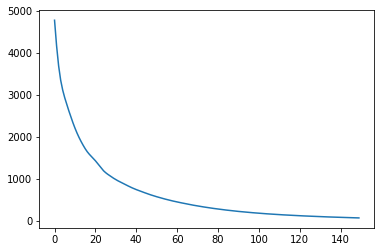

73.1870412827


In [20]:
#from sklearn.model_selection import train_test_split

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    b = []
    ac = []
    X_train, X_test, Y_train, Y_test = train_test_split(x_matrix_scale, y_matrix, test_size=0.33)
    for i in range(epochs):
        _, a = sess.run([optimizer,cost],feed_dict={x:X_train,y:Y_train})
        c = sess.run(accuracy,feed_dict={x:X_test,y:Y_test})
        b.append(a)
        ac.append(c)
    
    plt.plot(b)
    plt.show()
    
    print(100*max(ac))

## Results Analysis

The MLP neural network results nearly 70% of accuracy, which represents that from 10050 samples used for validation, almost 7035 were right classified and 3015 were wrong. The resuls may change due the train_test_split method uses random set generation, so the test and validation set are probably different for each call. 

Thinking in a real world application in autonomous cars, it would not be a successful solution as it permits many recognition mistakes and promotes a bad decision, putting lives in risk. As a first attempt for this problem, it is a good result, but it also needs a better approach as desired for future works in this subject, like application of different neural network concepts as convolutional neural network for example, and optimization of parameters as layers and number of inputs.